# Imports

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from os import walk
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
import numpy as np
from skimage.data import shepp_logan_phantom
from skimage.transform import radon, rescale, resize
from skimage import color
import math

# Configuration

In [3]:
pic_dir = "./tomograf-zdjecia/"

# Loading files

In [4]:
filenames = next(walk(pic_dir), (None, None, []))[2]  # [] if no file
images = dict()

for file in filenames:
    img = mpimg.imread(pic_dir+file)
    images[file.split('.')[0]] = img
    #plt.imshow(img)
    #plt.show()

# Quick overview

In [5]:
@interact
def show_images(image=list(images.keys())):
    plt.imshow(images[image])
    plt.show()

interactive(children=(Dropdown(description='image', options=('CT_ScoutView', 'Kolo', 'Kwadraty2', 'SADDLE_PE-l…

# Bresenham algorithm

In [6]:
# source: https://eduinf.waw.pl/inf/utils/002_roz/2008_06.php

def bresenham(x1, y1, x2, y2):
    pixels = []
    dx = abs(x2-x1)
    dy = abs(y2-y1)
    if x1 < x2:
        sx = 1
    else:
        sx = -1
    if y1 < y2:
        sy = 1
    else:
        sy = -1
    err = dx - dy
    while True:
        pixels.append((x1, y1))
        if x1 == x2 and y1 == y2:
            break
        e2 = 2 * err
        if e2 > -dy:
            err -= dy
            x1 += sx
        if e2 < dx:
            err += dx
            y1 += sy
    return pixels
print(bresenham(1,1, 7,5)) # test example (expected: [(1, 1), (2, 2), (3, 2), (4, 3), (5, 4), (6, 4), (7, 5)])

[(1, 1), (2, 2), (3, 2), (4, 3), (5, 4), (6, 4), (7, 5)]


# Radon Transform
#### Using scikit-image function

In [7]:
n = 1 # liczba detektorów
l = 1 # rozpiętość układu emitter/detektor

@interact
def ranon_transform(image=list(images.keys()),
                    n=widgets.IntSlider(min=90,max=720,step=90,value=180),
                    l=widgets.IntSlider(min=45,max=270,step=45,value=180)):
    
    img  = rescale(images[image], scale=0.2, mode='reflect', channel_axis=None)
    img = np.resize(img, (img.shape[0], img.shape[1]))
    img = img / 255.
    
    sinogram = radon(img)
    print(sinogram.shape, img.shape)
    plt.imshow(sinogram)
    #plt.imshow(images[image])
    plt.show()


interactive(children=(Dropdown(description='image', options=('CT_ScoutView', 'Kolo', 'Kwadraty2', 'SADDLE_PE-l…

# Only 4 angles

In [1]:
alpha = 90
angles = 360 // alpha

image = images['Kropka']
img  = rescale(image, scale=0.2, mode='reflect', channel_axis=None)
img = np.resize(img, (img.shape[0], img.shape[1]))
img = img / 255.

n = img.shape[0]
sinogram = np.zeros((n, angles))

d1 = [(img.shape[0]-1, i) for i in range(img.shape[0])]  
d2 = [(i, img.shape[1]-1) for i in range(img.shape[0])]  
d3 = [(0, i) for i in range(img.shape[0])]  
d4 = [(i, 0) for i in range(img.shape[0])]  

e1 = d3
e2 = d4
e3 = d1
e4 = d2

detectors = [d1, d2, d3, d4]
emitters = [e1, e2, e3, e4]

i = 0
for d, e in zip(detectors, emitters):
    for j in range(n):
        dx, dy = d[j][0], d[j][1]
        ex, ey = e[j][0], e[j][1]
        beam_coord = bresenham(ex, ey, dx, dy)
        pixels_sum = sum([img[coord] for coord in beam_coord])
        sinogram[j,i] += pixels_sum
    i += 1


plt.imshow(img)
plt.show()
plt.figure(figsize=(20,5))
plt.imshow(sinogram)
plt.show()

NameError: name 'images' is not defined

# Work in progress

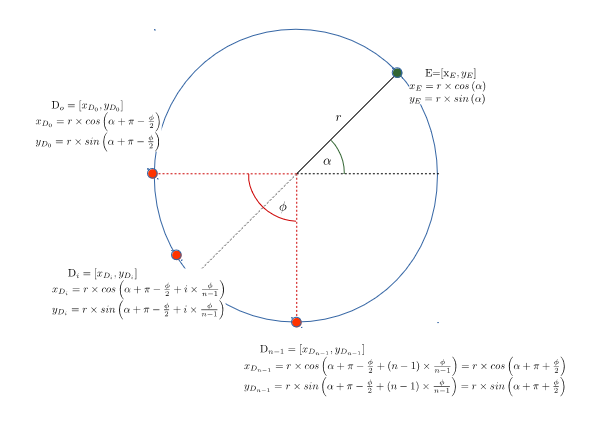

In [24]:
@interact
def debug(image=list(images.keys()),
                    n=widgets.IntSlider(min=10,max=200,step=10,value=80),
                    l=widgets.IntSlider(min=15,max=180,step=15,value=45),
                    delta=widgets.FloatSlider(min=0.5, max=5, step=0.5, value=1)):
    
    angles = np.arange(0, 180, delta)

    img = images[image]
    #img = color.rgb2gray(img)
    img  = rescale(img, scale=0.2, mode='reflect', channel_axis=None) # worse quality, faster calculations
    img = resize(img, (img.shape[0], img.shape[0]), anti_aliasing=True)

    img = img / 255.
    if n > img.shape[0]:
        n = img.shape[0]
    sinogram = np.zeros((n, len(angles)))

    phi = np.deg2rad(l)
    r = n/2
    detectors = []
    emitters = []
    Xe = []
    Ye = []
    Xd = []
    Yd = []
    for angle in angles:
        alpha = np.deg2rad(angle * delta)
        xe = np.round(r * np.cos(alpha)).astype(int)
        ye = np.round(r * np.sin(alpha)).astype(int)
        # ye = np.round((r**2 - xe**2)**(1/2)).astype(int)
        # x^2 + y^2 = r^2

        cur_detectors = []
        for i in range(n):
            xdi = np.round(r * np.cos(alpha + math.pi - phi/2 + i*phi/(n-1))).astype(int)
            ydi = np.round(r * np.sin(alpha + math.pi - phi/2 + i*phi/(n-1))).astype(int)
            cur_detectors.append((xdi, ydi))        
            Xd.append(xdi)
            Yd.append(ydi)

        detectors.append(cur_detectors)
        emitters.append((xe, ye))
        Xe.append(xe)
        Ye.append(ye)


    plt.plot(Xe,Ye,'x', label='emitters')
    plt.plot(Xd,Yd,'o', label='detectors')
    plt.legend()
    plt.show()

    i = 0
    for i, (detectors_i, emitters_i), in enumerate(zip(detectors, emitters)):
        xe, ye = emitters_i
        for j in range(len(detectors_i)):
            xd, yd = detectors_i[j]
            beam_coord = bresenham(xe, ye, xd, yd)
            pixels = [img[coord] for coord in beam_coord]
            sinogram[j,i] += sum(pixels) / len(pixels)

    fig, ax = plt.subplots(1,2, figsize=(10,5))
    ax[0].imshow(img)
    ax[1].imshow(sinogram)
    plt.show()

interactive(children=(Dropdown(description='image', options=('CT_ScoutView', 'Kolo', 'Kwadraty2', 'SADDLE_PE-l…

In [ ]:
# http://rknet.pl/student/2013_2014/pom/wyk/POM_Radon_Hough.pdf
# https://scikit-image.org/docs/stable/auto_examples/transform/plot_radon_transform.html

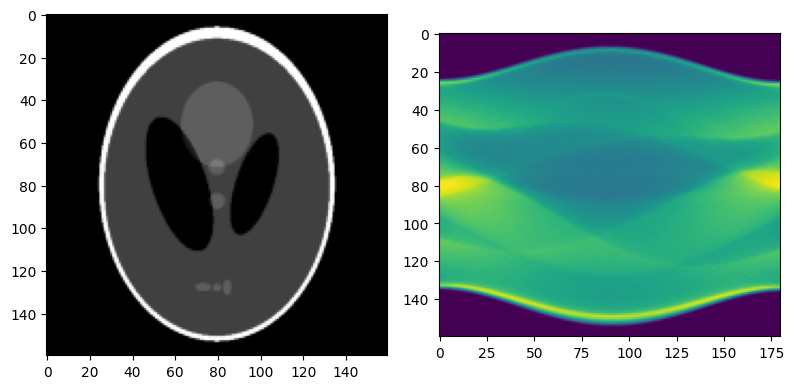

In [60]:
image = shepp_logan_phantom()
image = rescale(image, scale=0.4, mode='reflect', channel_axis=None)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4.5))

ax1.imshow(image, cmap=plt.cm.Greys_r)

bad_theta =[0,45,90,135,180]
sinogram = radon(image)
ax2.imshow(sinogram)

fig.tight_layout()
plt.show()